# mount google drive

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
cd gdrive/My Drive/app/heart_beat/heart_wuxin

[Errno 2] No such file or directory: 'gdrive/My Drive/app/heart_beat/heart_wuxin'
/content/gdrive/My Drive/app/heart_beat/heart_wuxin


In [24]:
pwd

'/content/gdrive/My Drive/app/heart_beat/heart_wuxin'

# read data from csv

In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import math
import random
import pickle
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

np.random.seed(42)

import pickle
from sklearn.preprocessing import OneHotEncoder

from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir())

['heart_wuxin.ipynb', 'test_data.csv', 'heart_wuxin.csv', 'heart_wuxin.h5', 'heart_wuxin1.png', 'heart_wuxin2.csv', 'heart_wuxin2.png', 'heart_wuxin3.csv', 'heart_wuxin3.png']


In [0]:
import pandas as pd
df = pd.read_csv("heart_wuxin.csv", header=None)
df2 = pd.read_csv('test_data.csv', header = None)

In [0]:
df2[500] = 1

In [0]:
df3 = pd.read_csv("heart_wuxin2.csv", header=None)
df4 = pd.read_csv("heart_wuxin3.csv", header=None)

In [0]:
df = pd.concat([df, df2, df3, df4], axis=0)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 0 to 207
Columns: 501 entries, 0 to 500
dtypes: float64(500), int64(1)
memory usage: 2.0 MB


In [31]:
df[500].value_counts()

0    344
1    166
Name: 500, dtype: int64

In [0]:
M = df.values

# convert data to numpy array

In [0]:
X = M[:, :-1]
y = M[:, -1].astype(int)

In [0]:
import numpy as np
C0 = np.argwhere(y == 0).flatten()  # argwhere 返回索引值 
# flatten 将二维矩阵转换为向量
C1 = np.argwhere(y == 1).flatten()

In [0]:
from sklearn.preprocessing import normalize
X = normalize(X)

In [71]:
X.shape

(510, 500)

# plot ECG

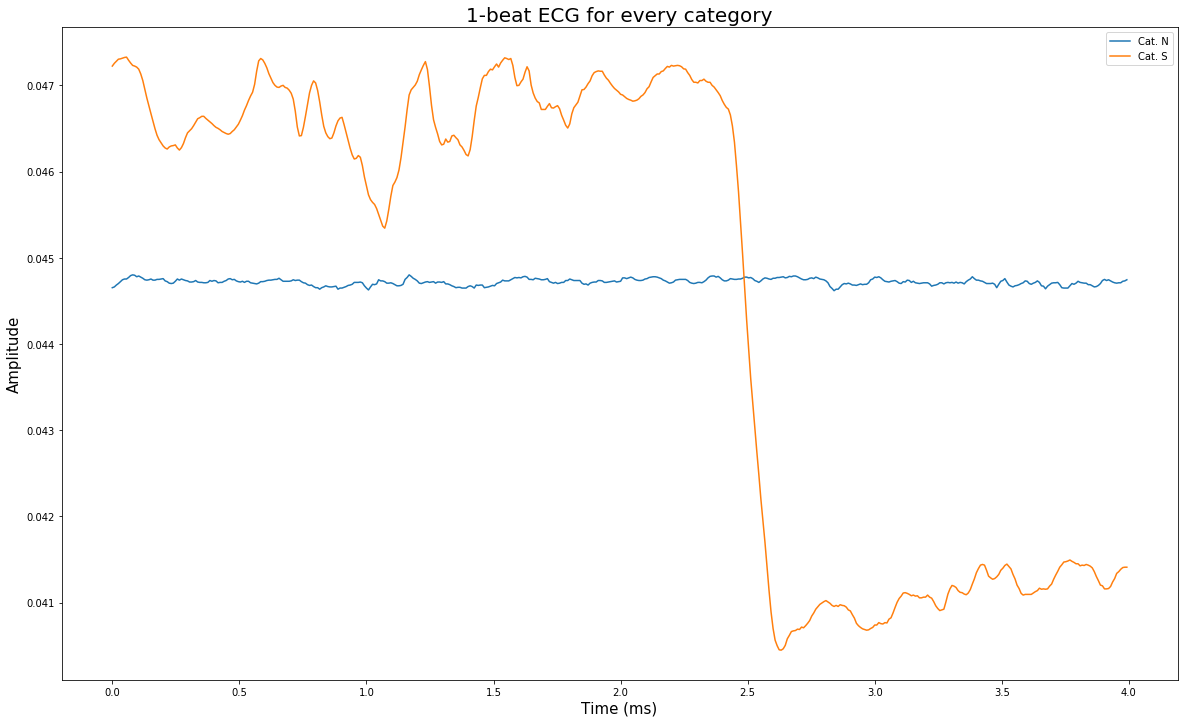

In [0]:
x = np.arange(0, 500)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][19], label="Cat. N")
plt.plot(x, X[C1, :][12], label="Cat. S")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

# prepare X and y

# data augmentation (kaggle)

In [0]:
def stretch(x):
    l = int(500 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 500:
        y_ = np.zeros(shape=(500, ))
        y_[:l] = y
    else:
        y_ = y[:500]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 500))
    for i in range(4):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

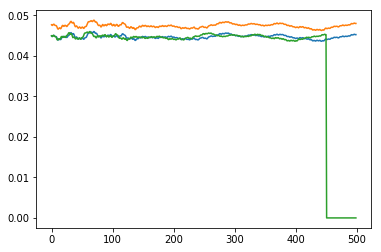

In [0]:
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

# prepare X for Conv 1D

In [0]:
X = np.expand_dims(X, -1)

In [73]:
X.shape

(510, 500, 1)

# y to onehot

In [39]:
y.shape

(510,)

In [0]:
from keras.utils.np_utils import *
y = to_categorical(y, 2)

In [41]:
y.shape

(510, 2)

# prepare X, y for Dense

In [0]:
from keras.utils.np_utils import *
y = to_categorical(y, 2)

In [0]:
X.shape

(302, 500)

# design Conv1D model from kaggle

In [0]:
from keras.layers import BatchNormalization, Dropout

nb, feature, depth = X.shape
inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(256)(F1)
BN1 = BatchNormalization()(D1)
A6 = Activation("relu")(BN1)
D2 = Dense(128)(A6)
BN2 = BatchNormalization()(D2)
A7 = Activation('relu')(BN2)
dp1 = Dropout(0.5)(A7)
D3 = Dense(2)(dp1)
BN3 = BatchNormalization()(D3)
A8 = Activation('softmax')(BN3)

model = Model(inputs=inp, outputs=A8)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 500, 1)       0                                            
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 496, 32)      192         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 496, 32)      5152        conv1d_34[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 496, 32)      0           conv1d_35[0][0]                  
__________________________________________________________________________________________________
conv1d_36 

## compile and training

In [0]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
import math

batch_size = 50
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = nb/(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=['accuracy'])

In [0]:
history_tl = model.fit(X, y, 
                    epochs=200,
                    batch_size=100,
                    validation_split=0.3)

Train on 357 samples, validate on 153 samples
Epoch 1/200
357/357 [==============================] - 2s 7ms/step - loss: 0.5881 - acc: 0.7059 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/200
357/357 [==============================] - 0s 399us/step - loss: 0.3901 - acc: 0.8207 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/200
357/357 [==============================] - 0s 406us/step - loss: 0.3685 - acc: 0.8599 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 4/200
357/357 [==============================] - 0s 394us/step - loss: 0.3552 - acc: 0.8683 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/200
357/357 [==============================] - 0s 392us/step - loss: 0.3070 - acc: 0.8824 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 6/200
357/357 [==============================] - 0s 365us/step - loss: 0.2854 - acc: 0.8992 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 7/200
357/357 [==============================] - 0s 357us/step - loss: 0.2564 - acc: 0.9188 - val_loss: 16.118

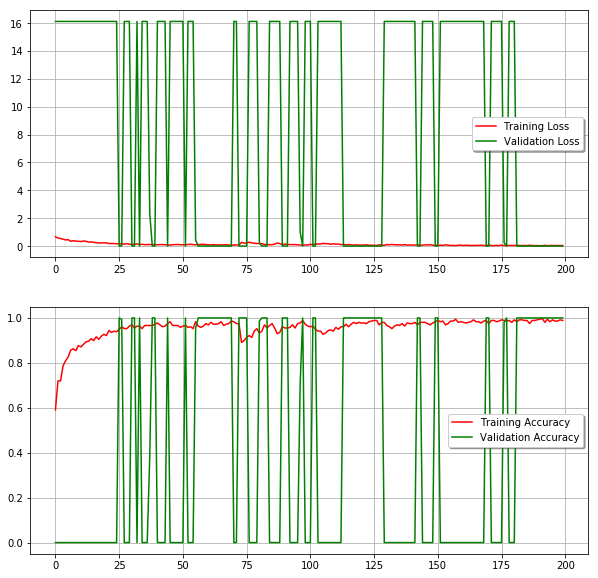

In [0]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(history_tl.history['loss'], color='r', label='Training Loss')
ax[0].plot(history_tl.history['val_loss'], color='g', label='Validation Loss')
ax[0].legend(loc='best',shadow=True)
ax[0].grid(True)

ax[1].plot(history_tl.history['acc'], color='r', label='Training Accuracy')
ax[1].plot(history_tl.history['val_acc'], color='g', label='Validation Accuracy')
ax[1].legend(loc='best',shadow=True)
ax[1].grid(True)
plt.savefig("heart_wuxin3.png")
plt.show()

In [0]:
model.save('heart_wuxin.h5')

# design ResNet50 Conv1D(softmax)

In [62]:
import tensorflow as tf

import keras
from keras.engine.input_layer import Input
import keras.backend as K

from keras.utils import plot_model, to_categorical
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv1D, BatchNormalization

from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 

from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
from keras.engine.topology import Layer

def identity_block(X, f, filter_numbers, stage, block):
    """
    Implementation of the identity block as defined in Figure 4.
    
    Arguments:
    X -- input tensor of shape (m, input_length_prev (n_w), input_Channel_prev (n_c).
    f -- kernel_size, integer, shape of convolution filter in the main path.
    filter_numbers -- python list of integers, defining the number of filters in the CONV layers of the main path.
    stage -- integer, used to name the layers, depending on their position in the network.
    block -- string/character, used to name the layers, depending on their position in the network.
    
    Returns:
    X -- output of the identity block, tensor of shape (n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filter_numbers
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First Conv layer
    X = Conv1D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
   
    
    # Second Conv layer
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third Conv layer
    X = Conv1D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2c')(X)

    # Merge with Residual shortcut
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, input_length_prev (n_w), input_Channel_prev (n_c))
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv1D(F1, 1, strides = s, name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv1D(F2, f, strides = 1, padding = "same", name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv1D(F3, 1, strides = 1, name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    #X = BatchNormalization(axis = 2, name = bn_name_base + '2c')(X)
    
    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv1D(F3, 1, strides = s, name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    #X_shortcut = BatchNormalization(axis = 2, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

def ResNet50(input_shape = (500, 1), max_pool_s=10, max_strides=5, kernel_size=3, strides = 2, f=3, ave_pool_size=5, n_out=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV1D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    Arguments:
    input_shape -- shape of the 1D data
    n_out -- integer, number of classes or output
    Returns:
    model -- a Model() instance in Keras
    params here were used in one of my projects. 
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    X = MaxPooling1D(max_pool_s, max_strides)(X_input) 
    
    # Zero-Padding
    X = ZeroPadding1D(3)(X)
    
    # stage 1, 64 filters, kernel_size=7
    X = Conv1D(64, kernel_size, strides=1, name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(3, strides=2)(X)

    # Stage 2
    X = convolutional_block(X, f, filters = [16, 16, 64], stage = 2, block='a', s = 1)
    X = identity_block(X, f, [16, 16, 64], stage=2, block='b')
    X = identity_block(X, f, [16, 16, 64], stage=2, block='c')

    ### START CODE HERE ###
    
    X = convolutional_block(X, f, filters = [32,32,128], stage = 3, block='a', s = 2)
    X = identity_block(X, f, [32,32,128], stage=3, block='b')
    X = identity_block(X, f, [32,32,128], stage=3, block='c')
    X = identity_block(X, f, [32,32,128], stage=3, block='d')

    # Stage 4 (≈6 lines)
    
    X = convolutional_block(X, f, filters = [64, 64, 256], stage = 4, block='a', s = 2)
    X = identity_block(X, f, [64, 64, 256], stage=4, block='b')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='c')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='d')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='e')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f, filters = [64, 64, 256], stage = 5, block='a', s = 2)
    X = identity_block(X, f, [64, 64, 256], stage=5, block='b')
    X = identity_block(X, f, [64, 64, 256], stage=5, block='c')

    X = AveragePooling1D(ave_pool_size)(X)
    
    # output layer
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    
    # For regression
    X = Dense(n_out, name='fc-dense', kernel_initializer = glorot_uniform(seed=0), 
              kernel_regularizer=regularizers.l2(0.2), bias_regularizer=regularizers.l2(0.2))(X)
    
    # for classification, if n_out =1, add:  
    # X = Activation('sigmoid')(X)

    # for classification, if n_out > 1, add:  
    X = Activation('softmax')(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50_1d')

    return model

model = ResNet50()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 500, 1)       0                                            
__________________________________________________________________________________________________
max_pooling1d_11 (MaxPooling1D) (None, 99, 1)        0           input_6[0][0]                    
__________________________________________________________________________________________________
zero_padding1d_6 (ZeroPadding1D (None, 105, 1)       0           max_pooling1d_11[0][0]           
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 103, 64)      256         zero_padding1d_6[0][0]           
__________________________________________________________________________________________________
bn_conv1 (

## training

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=['accuracy'])

In [64]:
history_res = model.fit(X, y, 
                       validation_split=0.3,
                       batch_size=100,
                       epochs=100)

Train on 357 samples, validate on 153 samples
Epoch 1/100
357/357 [==============================] - 22s 62ms/step - loss: 3.2621 - acc: 0.5406 - val_loss: 16.8707 - val_acc: 0.0000e+00
Epoch 2/100
357/357 [==============================] - 0s 1ms/step - loss: 1.7679 - acc: 0.6891 - val_loss: 16.8596 - val_acc: 0.0000e+00
Epoch 3/100
357/357 [==============================] - 0s 1ms/step - loss: 1.5003 - acc: 0.8319 - val_loss: 16.8476 - val_acc: 0.0000e+00
Epoch 4/100
357/357 [==============================] - 0s 1ms/step - loss: 1.1612 - acc: 0.8683 - val_loss: 16.8351 - val_acc: 0.0000e+00
Epoch 5/100
357/357 [==============================] - 0s 1ms/step - loss: 1.1151 - acc: 0.8964 - val_loss: 16.8222 - val_acc: 0.0000e+00
Epoch 6/100
357/357 [==============================] - 0s 1ms/step - loss: 1.0848 - acc: 0.9300 - val_loss: 16.8088 - val_acc: 0.0000e+00
Epoch 7/100
357/357 [==============================] - 0s 1ms/step - loss: 1.0363 - acc: 0.9216 - val_loss: 16.7948 - val_ac

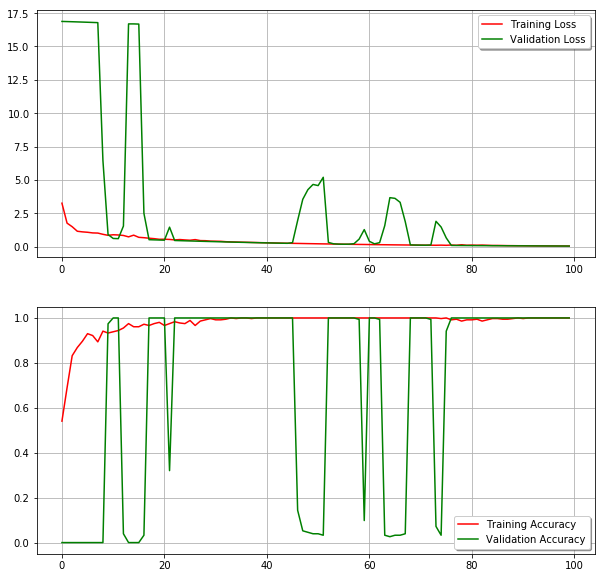

In [83]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(history_res.history['loss'], color='r', label='Training Loss')
ax[0].plot(history_res.history['val_loss'], color='g', label='Validation Loss')
ax[0].legend(loc='best',shadow=True)
ax[0].grid(True)

ax[1].plot(history_res.history['acc'], color='r', label='Training Accuracy')
ax[1].plot(history_res.history['val_acc'], color='g', label='Validation Accuracy')
ax[1].legend(loc='best',shadow=True)
ax[1].grid(True)
plt.savefig("ResNet_100_softmax.png")
plt.show()

# ResNet 50 sigmoid

In [79]:
import tensorflow as tf

import keras
from keras.engine.input_layer import Input
import keras.backend as K

from keras.utils import plot_model, to_categorical
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv1D, BatchNormalization

from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 

from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
from keras.engine.topology import Layer

def identity_block(X, f, filter_numbers, stage, block):
    """
    Implementation of the identity block as defined in Figure 4.
    
    Arguments:
    X -- input tensor of shape (m, input_length_prev (n_w), input_Channel_prev (n_c).
    f -- kernel_size, integer, shape of convolution filter in the main path.
    filter_numbers -- python list of integers, defining the number of filters in the CONV layers of the main path.
    stage -- integer, used to name the layers, depending on their position in the network.
    block -- string/character, used to name the layers, depending on their position in the network.
    
    Returns:
    X -- output of the identity block, tensor of shape (n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filter_numbers
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First Conv layer
    X = Conv1D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
   
    
    # Second Conv layer
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third Conv layer
    X = Conv1D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2c')(X)

    # Merge with Residual shortcut
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, input_length_prev (n_w), input_Channel_prev (n_c))
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv1D(F1, 1, strides = s, name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv1D(F2, f, strides = 1, padding = "same", name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv1D(F3, 1, strides = 1, name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    #X = BatchNormalization(axis = 2, name = bn_name_base + '2c')(X)
    
    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv1D(F3, 1, strides = s, name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    #X_shortcut = BatchNormalization(axis = 2, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

def ResNet50(input_shape = (500, 1), max_pool_s=10, max_strides=5, kernel_size=3, strides = 2, f=3, ave_pool_size=5, n_out=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV1D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    Arguments:
    input_shape -- shape of the 1D data
    n_out -- integer, number of classes or output
    Returns:
    model -- a Model() instance in Keras
    params here were used in one of my projects. 
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    X = MaxPooling1D(max_pool_s, max_strides)(X_input) 
    
    # Zero-Padding
    X = ZeroPadding1D(3)(X)
    
    # stage 1, 64 filters, kernel_size=7
    X = Conv1D(64, kernel_size, strides=1, name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(3, strides=2)(X)

    # Stage 2
    X = convolutional_block(X, f, filters = [16, 16, 64], stage = 2, block='a', s = 1)
    X = identity_block(X, f, [16, 16, 64], stage=2, block='b')
    X = identity_block(X, f, [16, 16, 64], stage=2, block='c')

    ### START CODE HERE ###
    
    X = convolutional_block(X, f, filters = [32,32,128], stage = 3, block='a', s = 2)
    X = identity_block(X, f, [32,32,128], stage=3, block='b')
    X = identity_block(X, f, [32,32,128], stage=3, block='c')
    X = identity_block(X, f, [32,32,128], stage=3, block='d')

    # Stage 4 (≈6 lines)
    
    X = convolutional_block(X, f, filters = [64, 64, 256], stage = 4, block='a', s = 2)
    X = identity_block(X, f, [64, 64, 256], stage=4, block='b')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='c')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='d')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='e')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f, filters = [64, 64, 256], stage = 5, block='a', s = 2)
    X = identity_block(X, f, [64, 64, 256], stage=5, block='b')
    X = identity_block(X, f, [64, 64, 256], stage=5, block='c')

    X = AveragePooling1D(ave_pool_size)(X)
    
    # output layer
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    
    # For regression
    X = Dense(n_out, name='fc-dense', kernel_initializer = glorot_uniform(seed=0), 
              kernel_regularizer=regularizers.l2(0.2), bias_regularizer=regularizers.l2(0.2))(X)
    
    # for classification, if n_out =1, add:  
    X = Activation('sigmoid')(X)

    # for classification, if n_out > 1, add:  
    # X = Activation('softmax')(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50_1d')

    return model

model = ResNet50(n_out=1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 500, 1)       0                                            
__________________________________________________________________________________________________
max_pooling1d_17 (MaxPooling1D) (None, 99, 1)        0           input_9[0][0]                    
__________________________________________________________________________________________________
zero_padding1d_9 (ZeroPadding1D (None, 105, 1)       0           max_pooling1d_17[0][0]           
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 103, 64)      256         zero_padding1d_9[0][0]           
__________________________________________________________________________________________________
bn_conv1 (

In [80]:
model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])
history_res_sig = model.fit(X, y,
         batch_size=400,
         epochs=50,
         validation_split=0.3)

Train on 357 samples, validate on 153 samples
Epoch 1/50
357/357 [==============================] - 28s 79ms/step - loss: 3.1847 - acc: 0.4650 - val_loss: 16.3453 - val_acc: 0.0000e+00
Epoch 2/50
357/357 [==============================] - 0s 404us/step - loss: 1.5002 - acc: 0.5686 - val_loss: 16.3437 - val_acc: 0.0000e+00
Epoch 3/50
357/357 [==============================] - 0s 339us/step - loss: 1.6328 - acc: 0.5742 - val_loss: 16.3416 - val_acc: 0.0000e+00
Epoch 4/50
357/357 [==============================] - 0s 347us/step - loss: 1.4920 - acc: 0.5574 - val_loss: 16.3396 - val_acc: 0.0000e+00
Epoch 5/50
357/357 [==============================] - 0s 347us/step - loss: 1.1684 - acc: 0.6751 - val_loss: 16.3375 - val_acc: 0.0000e+00
Epoch 6/50
357/357 [==============================] - 0s 296us/step - loss: 1.0946 - acc: 0.7171 - val_loss: 16.3353 - val_acc: 0.0000e+00
Epoch 7/50
357/357 [==============================] - 0s 285us/step - loss: 1.0429 - acc: 0.7115 - val_loss: 16.3331 - v

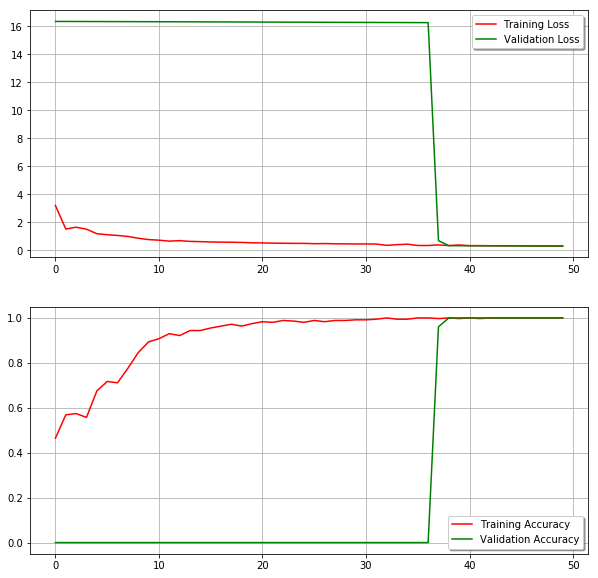

In [82]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(history_res_sig.history['loss'], color='r', label='Training Loss')
ax[0].plot(history_res_sig.history['val_loss'], color='g', label='Validation Loss')
ax[0].legend(loc='best',shadow=True)
ax[0].grid(True)

ax[1].plot(history_res_sig.history['acc'], color='r', label='Training Accuracy')
ax[1].plot(history_res_sig.history['val_acc'], color='g', label='Validation Accuracy')
ax[1].legend(loc='best',shadow=True)
ax[1].grid(True)
plt.savefig("ResNet_50_sig.png")
plt.show()

# design Dense network

In [0]:
nb, feature = X.shape
inp = Input(shape=(feature,))
fc1 = Dense(128)(inp)
dp1 = Dropout(0.5)(fc1)
ac1 = Activation('relu')(dp1)
fc2 = Dense(32)(ac1)
dp2 = Dropout(0.5)(fc2)
ac2 = Activation('relu')(dp2)
fc3 = Dense(2)(ac2)
ac3 = Activation('softmax')(fc3)
model_dense = Model(inputs=inp, outputs=ac3)
model_dense.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 500)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               64128     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
activation_138 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
activation_139 (Activation)  (None, 32)                0         
__________

In [0]:
model_dense.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
history_dense = model_dense.fit(X, y, 
                    epochs=200, 
                    batch_size=100, 
                    verbose=2, 
                    validation_split=0.3)

Train on 211 samples, validate on 91 samples
Epoch 1/200
 - 3s - loss: 8.4028 - acc: 0.4787 - val_loss: 11.6900 - val_acc: 0.2747
Epoch 2/200
 - 0s - loss: 6.5502 - acc: 0.5924 - val_loss: 11.6900 - val_acc: 0.2747
Epoch 3/200
 - 0s - loss: 7.1276 - acc: 0.5545 - val_loss: 11.6900 - val_acc: 0.2747
Epoch 4/200
 - 0s - loss: 6.0764 - acc: 0.6209 - val_loss: 11.6900 - val_acc: 0.2747
Epoch 5/200
 - 0s - loss: 5.2708 - acc: 0.6730 - val_loss: 11.6900 - val_acc: 0.2747
Epoch 6/200
 - 0s - loss: 5.7640 - acc: 0.6398 - val_loss: 11.6900 - val_acc: 0.2747
Epoch 7/200
 - 0s - loss: 5.9583 - acc: 0.6303 - val_loss: 11.6900 - val_acc: 0.2747
Epoch 8/200
 - 0s - loss: 5.9299 - acc: 0.6303 - val_loss: 11.6900 - val_acc: 0.2747
Epoch 9/200
 - 0s - loss: 5.7292 - acc: 0.6445 - val_loss: 11.6900 - val_acc: 0.2747
Epoch 10/200
 - 0s - loss: 5.4236 - acc: 0.6635 - val_loss: 11.6900 - val_acc: 0.2747
Epoch 11/200
 - 0s - loss: 5.6528 - acc: 0.6493 - val_loss: 11.6900 - val_acc: 0.2747
Epoch 12/200
 - 0s

# kaggle

In [0]:
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 500)
classe = np.ones(shape=(result.shape[0],), dtype=int)*3
X = np.vstack([X, result])
y = np.hstack([y, classe])

In [0]:
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [0]:
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

del X
del y

In [0]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [0]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150,)
X_test (4000, 187, 1)
y_test (4000,)


In [0]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


# import keras

# Design Conv1D model

In [0]:
nb, feature, depth = X_train.shape
inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Activation('softmax')(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 187, 1)       0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 183, 32)      192         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 183, 32)      5152        conv1d_12[0][0]                  
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 183, 32)      0           conv1d_13[0][0]                  
__________________________________________________________________________________________________
conv1d_14 

# Training

In [0]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
import math

batch_size = 500
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = nb/(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
history = model.fit(X_train, y_train, 
                    epochs=75, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lrate])

Train on 109150 samples, validate on 4000 samples
Epoch 1/75
 - 6s - loss: 0.3827 - acc: 0.8854 - val_loss: 0.8011 - val_acc: 0.7468
Epoch 2/75
 - 3s - loss: 0.1456 - acc: 0.9603 - val_loss: 0.8482 - val_acc: 0.7710
Epoch 3/75
 - 3s - loss: 0.1038 - acc: 0.9713 - val_loss: 0.5621 - val_acc: 0.8360
Epoch 4/75
 - 3s - loss: 0.0856 - acc: 0.9758 - val_loss: 0.4978 - val_acc: 0.8595
Epoch 5/75
 - 3s - loss: 0.0727 - acc: 0.9795 - val_loss: 0.3745 - val_acc: 0.8895
Epoch 6/75
 - 3s - loss: 0.0666 - acc: 0.9809 - val_loss: 0.4162 - val_acc: 0.8808
Epoch 7/75
 - 3s - loss: 0.0610 - acc: 0.9824 - val_loss: 0.4075 - val_acc: 0.8770
Epoch 8/75
 - 3s - loss: 0.0558 - acc: 0.9834 - val_loss: 0.3196 - val_acc: 0.9040
Epoch 9/75
 - 3s - loss: 0.0524 - acc: 0.9841 - val_loss: 0.3786 - val_acc: 0.8882
Epoch 10/75
 - 3s - loss: 0.0477 - acc: 0.9858 - val_loss: 0.2925 - val_acc: 0.9105
Epoch 11/75
 - 3s - loss: 0.0446 - acc: 0.9862 - val_loss: 0.2861 - val_acc: 0.9165
Epoch 12/75
 - 3s - loss: 0.0431 - 

# plot the loss and accuracy

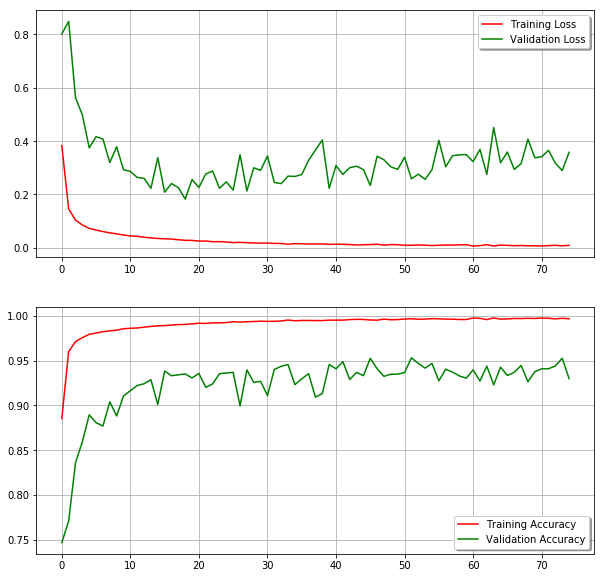

In [0]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(history.history['loss'], color='r', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='g', label='Validation Loss')
ax[0].legend(loc='best',shadow=True)
ax[0].grid(True)

ax[1].plot(history.history['acc'], color='r', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='g', label='Validation Accuracy')
ax[1].legend(loc='best',shadow=True)
ax[1].grid(True)
plt.savefig("keras_conv_mnist.png")
plt.show()